# ***Bitcoin Price Prediction Using LSTM and Technical Indicators: Analyzing Overfitting and Model Performance***

# Introduction

Accurate cryptocurrency price prediction is crucial for informed investment decisions. In recent 
years, the cryptocurrency market has exhibited extreme volatility, presenting both significant 
opportunities and risks underscores the need for robust predictive models. This study investigates the 
application of Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks 
for predicting Bitcoin prices. By leveraging historical price data and incorporating technical indicators, 
the model aims to capture complex patterns and dependencies within the cryptocurrency market. The 
proposed methodology involves data preprocessing, feature engineering, and model training using 
LSTM architecture. Model performance is evaluated using metrics such as Mean Absolute Error 
(MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared. The results 
demonstrate the potential of LSTM networks in predicting Bitcoin prices, providing not more than insights and aid to 
the investors, traders, and financial institutions in mitigating losses and capitalizing on market trends.


# Model Performance and Overfitting Discussion

The model demonstrates exceptional performance, as evidenced by the evaluation metrics:

MAE (Mean Absolute Error): 0.01

MSE (Mean Squared Error): 0.00

RMSE (Root Mean Squared Error): 0.02

R-squared: 0.99


These results indicate that the model can predict Bitcoin prices with a high degree of accuracy on the test data. The R-squared value of 0.99 suggests that the model can explain 99% of the variance in the test data.

However, I can see that an overfitting is happening here that I tried to overcome it with one dropout layer of 0.2 dropout rate.

It might be learning the noise and specific patterns in the training data rather than capturing the underlying trends that generalize to new or unseen data.

While the high R-squared value and low error metrics are give good first impression but I think this signal that the model has been overly tailored to the historical data used for training.

# Implications of Overfitting in Price Prediction

An overfitted model may perform well on historical data but fail to generalize to future data, leading to inaccurate predictions in real-world scenarios.
While the goal of price prediction is to achieve the highest possible accuracy, it's crucial to ensure that the model can 
generalize beyond the specific dataset it was trained on.


# Importing Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
import tensorflow as tf


# 1.Data Preprocessing


I have used historical Bitcoin price dataset from Yahoo finance.
After aquiring the data set I included in it the technical indicators and target variables.

Technical indicators: from pandas_ta library

1. RSI (Relative Strength Index)

2. EMA (Exponential Moving Average):fast-medium-slow

3. MACD (Moving Average Convergence Divergence): that returns 3 values 

    [MACD Line:The difference between the 12-day EMA and the 26-day EMA.]

    [Signal Line: A 9-day EMA of the MACD line, used as a trigger for buy and sell signals.]

    [Histogram: The difference between the MACD line and the signal line.]
    
    
Target Variables:
1. Target: the difference between the closing price and the opening price of a specific day.
1. TargetClass: takes 1 if the "Target" is positive and 0 if it is negative.
2. TargetNextClose: represents the adjusted closing price of Bitcoin on the next trading day (shifted by -1), serving as the primary target for the model's predictions.

In [33]:
# Load data
data=pd.read_csv("BTC-USD.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [34]:
# Preprocess data
data['RSI'] = ta.rsi(data['Close'], length=15)
data['EMAF'] = ta.ema(data['Close'], length=20)
data['EMAM'] = ta.ema(data['Close'], length=100)
data['EMAS'] = ta.ema(data['Close'], length=150)
data[['MACD', 'signal columns', 'histogram']] = ta.macd(data['Close'])
data['Target'] = data['Close'] - data['Open']
data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]
data['TargetNextClose'] = data['Adj Close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)

data.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,MACD,signal columns,histogram,Target,TargetClass,TargetNextClose
0,149,2015-02-13,221.968994,240.259003,221.261993,235.427002,235.427002,42744400,50.019072,229.312807,288.640505,327.932773,-7.128940,2.081002,-9.209942,13.458008,1,257.321014
1,150,2015-02-14,235.528000,259.808014,235.528000,257.321014,257.321014,49732500,58.174526,231.980256,288.020317,326.997518,-4.103906,4.084829,-8.188735,21.793014,1,234.824997
2,151,2015-02-15,257.506989,265.610992,227.684006,234.824997,234.824997,56552400,49.315763,232.251183,286.966944,325.776690,-3.481651,3.765667,-7.247318,-22.681992,0,233.843002
3,152,2015-02-16,234.824997,239.520996,229.022003,233.843002,233.843002,28153700,48.967016,232.402785,285.914985,324.559025,-3.032787,3.371624,-6.404412,-0.981995,0,243.610001
4,153,2015-02-17,233.421997,245.774994,232.313995,243.610001,243.610001,27363100,52.543343,233.470139,285.077263,323.486853,-1.867419,3.629595,-5.497013,10.188004,1,236.326004


# Feature Scaling with MinMaxScaler

The features were normalized using the MinMaxScaler from the sklearn library.
I normalized the the first 18 coloumns after droping the **Date**, **Close** and **index** columns in the range of 0 to 1.

In [38]:
# Feature scaling
data_set = data.iloc[:, 0:18]
data_set.drop(['Date', 'Close', 'index'], axis=1, inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = scaler.fit_transform(data_set)
print(data_set_scaled)
data_set.head()

[[1.63319805e-04 2.23403381e-04 3.04985399e-04 ... 5.09455504e-01

  1.00000000e+00 6.42570167e-04]

 [3.49392742e-04 4.89281409e-04 5.05535085e-04 ... 5.10015892e-01

  1.00000000e+00 3.33868515e-04]

 [6.51014782e-04 5.68205317e-04 3.95265229e-04 ... 5.07025701e-01

  0.00000000e+00 3.20393087e-04]

 ...

 [8.52520426e-01 8.53603492e-01 8.52997337e-01 ... 4.31589038e-01

  0.00000000e+00 8.62314734e-01]

 [8.36856198e-01 8.59299801e-01 8.49777316e-01 ... 6.33520938e-01

  1.00000000e+00 8.31340527e-01]

 [8.62436134e-01 8.59868688e-01 8.43601792e-01 ... 3.56441637e-01

  0.00000000e+00 8.30732019e-01]]


,Open,High,Low,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,MACD,signal columns,histogram,Target,TargetClass,TargetNextClose
0,221.968994,240.259003,221.261993,235.427002,42744400,50.019072,229.312807,288.640505,327.932773,-7.128940,2.081002,-9.209942,13.458008,1,257.321014
1,235.528000,259.808014,235.528000,257.321014,49732500,58.174526,231.980256,288.020317,326.997518,-4.103906,4.084829,-8.188735,21.793014,1,234.824997
2,257.506989,265.610992,227.684006,234.824997,56552400,49.315763,232.251183,286.966944,325.776690,-3.481651,3.765667,-7.247318,-22.681992,0,233.843002
3,234.824997,239.520996,229.022003,233.843002,28153700,48.967016,232.402785,285.914985,324.559025,-3.032787,3.371624,-6.404412,-0.981995,0,243.610001
4,233.421997,245.774994,232.313995,243.610001,27363100,52.543343,233.470139,285.077263,323.486853,-1.867419,3.629595,-5.497013,10.188004,1,236.326004


# 2. LSTM Model Architecture

**1. **Shape engineering of the Dataset for LSTM input:****

we need to reshape the data as follows (samples, timesteps, features) to be suitable for the LSTM input.

Where:

1. samples: The number of data points or price instances.

2. timesteps: The number of time steps or "backcandles" used to predict the future values (in this case, 30).

3. features: The number of independent variables used as input (in this case, 12 features).

**Creating the Input Dataset for LSTM:**

1. backcandles = 30: This sets the number of past time steps that will be used to predict future values, meaning the model looks at 30 consecutive timesteps for each prediction.

2. we loop over the features (12 columns), for each feature we create sequences of 30 timesteps

3. The past 30 timesteps of each feature are appended to the 2D list (with features and timesteps) that contains the 30-timestep sequence for each feature for each training example.

4. reshape X, it should have the shape:(samples, 30, 12)

5. selects the target variable: "TargetNextClose" 

6. Reshapes the target data into the shape (samples, 1), Each target value corresponds to the 30 backcandles used as input.

In [41]:
# Create dataset for LSTM
X = []
backcandles = 30
for j in range(12):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])
        
#reshape the list to the form that is accepted by the LSTM model
X = np.moveaxis(X, [0], [2])
X = np.array(X)

#select the target variable "TargetNextClose"
yi = np.array(data_set_scaled[backcandles:, -1])
y = np.reshape(yi, (len(yi), 1))

print(X[1][1:3])
print(X.shape)
print(yi.shape)
print(y.shape)

[[6.51014782e-04 5.68205317e-04 3.95265229e-04 3.33868515e-04

  1.30931867e-04 4.65272382e-01 4.28794845e-05 7.50946193e-04

  1.36728937e-03 4.78092531e-01 5.66126404e-01 4.65247700e-01]

 [3.39745292e-04 2.13366052e-04 4.14074618e-04 3.20393087e-04

  5.00140558e-05 4.61078262e-01 4.50917968e-05 7.33428260e-04

  1.34557327e-03 4.78135028e-01 5.65995049e-01 4.65336189e-01]]

(3345, 30, 12)

(3345,)

(3345, 1)


In [42]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3177, 30, 12)

X_test shape: (168, 30, 12)

y_train shape: (3177, 1)

y_test shape: (168, 1)


**2. LSTM Model Architecture:**

1. LSTM Layer: The model includes an LSTM layer with 150 units which has robust capability to learn from the temporal patterns capturing both short-term dependencies and long-term trends.

2. Dropout for Regularization: One dropout layer with a rate of 0.2 to force the model to learn more robust features that generalize better to unseen data

3. Dense Layer for Output: This layer uses a linear activation function which is suitable for predicting continuous values, such as the price of bitcoin.

**Optimizer and Loss Function**

1. Adam Optimizer: known for its effectiveness in handling sparse gradients on noisy problems, which is typical in financial datasets like Bitcoin price data.

2. Mean Squared Error Loss Function.

**Hyperparameter**

1. Batch Size (15): small batch size is chosen to provide a more accurate estimate of the gradient.

2. Epochs (30): which allows sufficient iterations for the weights to converge to a good solution without overfitting, as evidenced by stable validation loss metrics.

In [17]:
# LSTM model
lstm_input = Input(shape=(backcandles, 12), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dropout(0.2)(inputs)  # Added dropout for regularization
inputs = Dense(1, name="dense_layer")(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')

history = model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split=0.1)

Epoch 1/30

191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0103 - val_loss: 8.5788e-04

Epoch 2/30

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0015 - val_loss: 4.6624e-04

Epoch 3/30

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011 - val_loss: 5.4038e-04

Epoch 4/30

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.1089e-04 - val_loss: 4.5638e-04

Epoch 5/30

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.0465e-04 - val_loss: 4.4651e-04

Epoch 6/30

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.3082e-04 - val_loss: 4.7306e-04

Epoch 7/30

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.9130e-04 - val_loss: 6.0063e-04

Epoch 8/30

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.2657e-04 - val_loss: 3.6745e-04

Epoch 9/30

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.5696e-04 - val_loss: 4.6645e-04

Epoch 10/30

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.4444e-04 - val_loss: 3.6589e-04

Epoch 11/30

191/191 ━━━━━━━━━━━━━━━━━━━━

In [18]:
# Predictions
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


**Evaluation Metrics**

1. MAE: measures how far off the predictions are from the true values, A lower MAE means the model's predictions are close to the actual values.

2. MSE: calculates the average of the squared differences between actual and predicted values, a lower MSE indicates better model performance.

3. RMSE: the square root of the Mean Squared Error, imilar to MSE, but it is more interpretable since it’s in the same units as the data.

4. R²: explains how much of the variance in the target variable is captured by the model. An R² value close to 1 indicates that the model explains most of the variance in the data.

In [19]:
# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

MAE: 0.01

MSE: 0.00

RMSE: 0.02

R-squared: 0.99


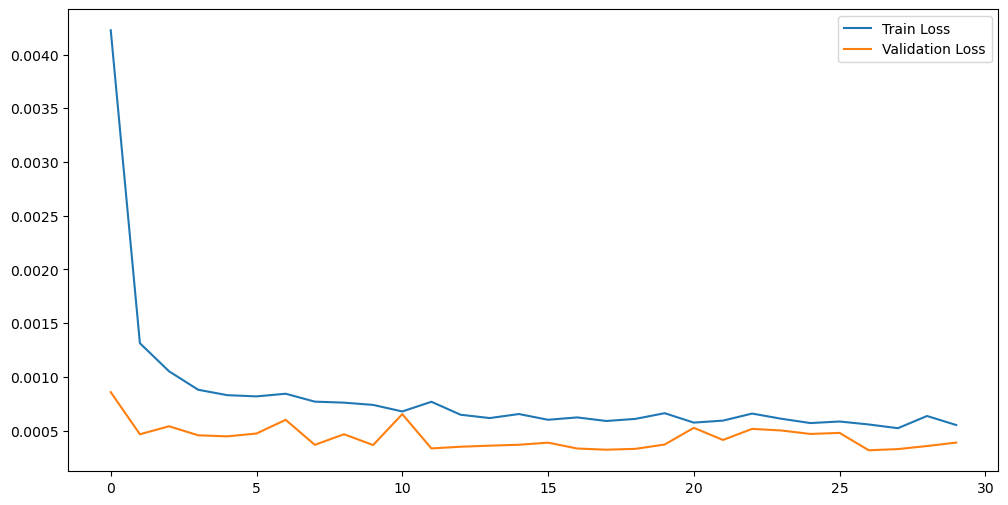

In [20]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

The plot suggests that the model has been trained effectively, with good initial learning and a reasonable level of generalization. However, the plateauing of the validation loss curve indicates that further training might not lead to significant improvements and could potentially lead to overfitting.



100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


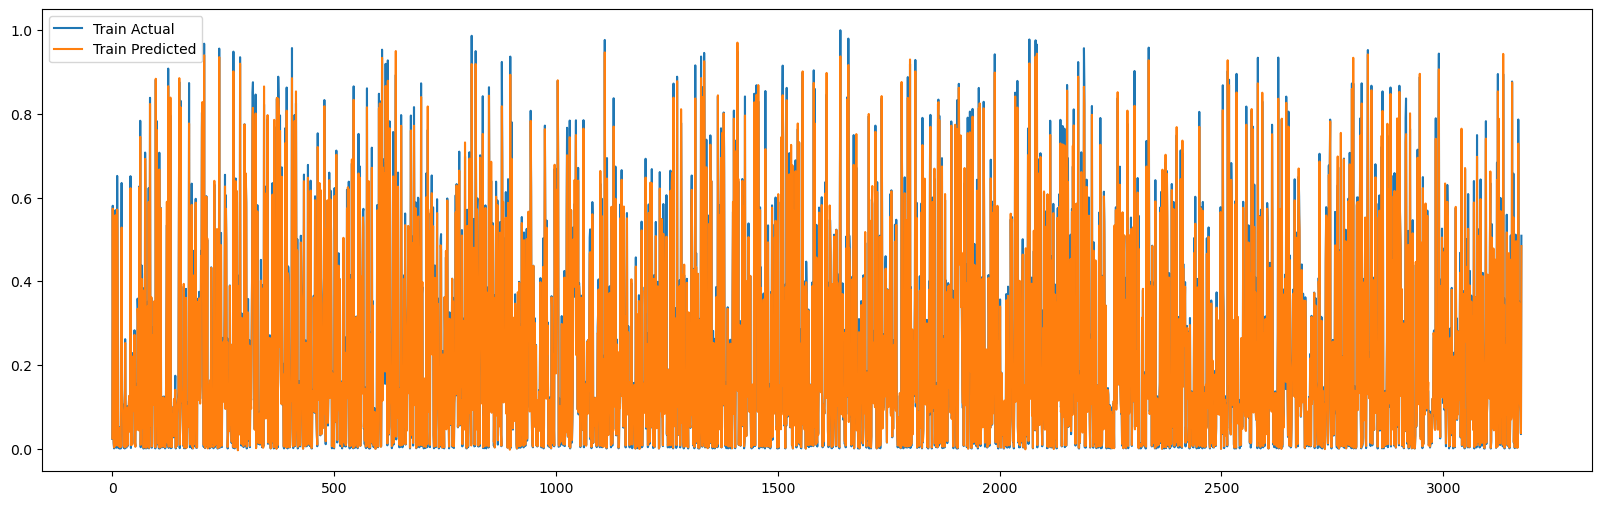

In [22]:
plt.figure(figsize=(20, 6))
plt.plot(y_train, label='Train Actual')
plt.plot(model.predict(X_train), label='Train Predicted')
plt.legend()
plt.show()

The close alignment between the actual and predicted lines during training suggests that your model is learning effectively from historical data.

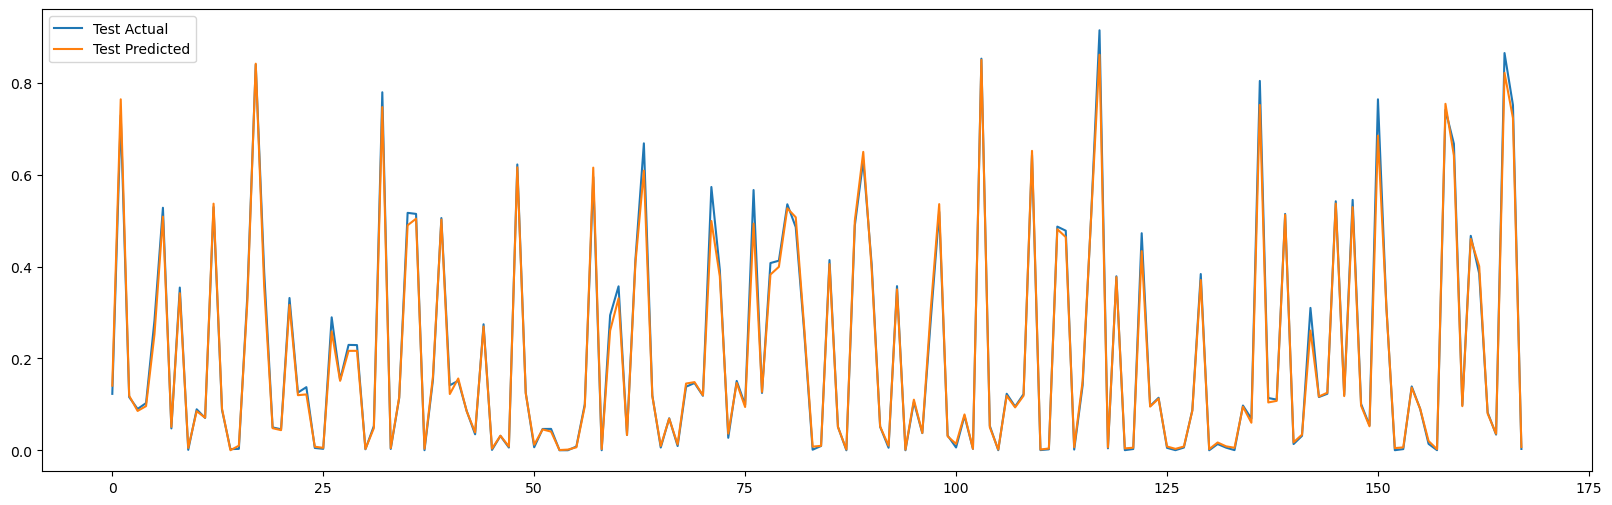

In [23]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Test Actual')
plt.plot(y_pred, label='Test Predicted')
plt.legend()
plt.show()

The "Test Predicted" line closely tracking the "Test Actual" line. This indicates that the model or method used to generate the "Test Predicted" values is capturing the trends and variations in the actual data quite well.

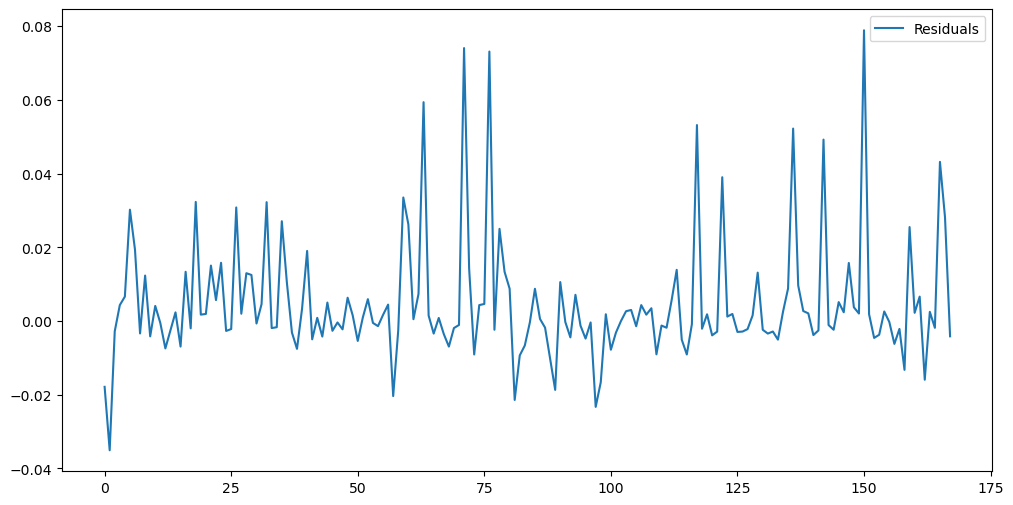

In [24]:
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.legend()
plt.show()

The residual plot displays the difference between the actual and predicted values (residuals) over time. Ideally, a residual plot should show a random scatter of points around the horizontal axis, indicating that the model captures the underlying pattern in the data well.

The spread of the residuals is not constant over time. There are periods of higher volatility (larger residuals) and lower volatility (smaller residuals). This indicates that the model's error variance is not constant.

There are a few points that deviate significantly from the general pattern, and the spread of the residuals is not constant over time.

There is no obvious patterns in the residual but the outliers indicates potential bias.

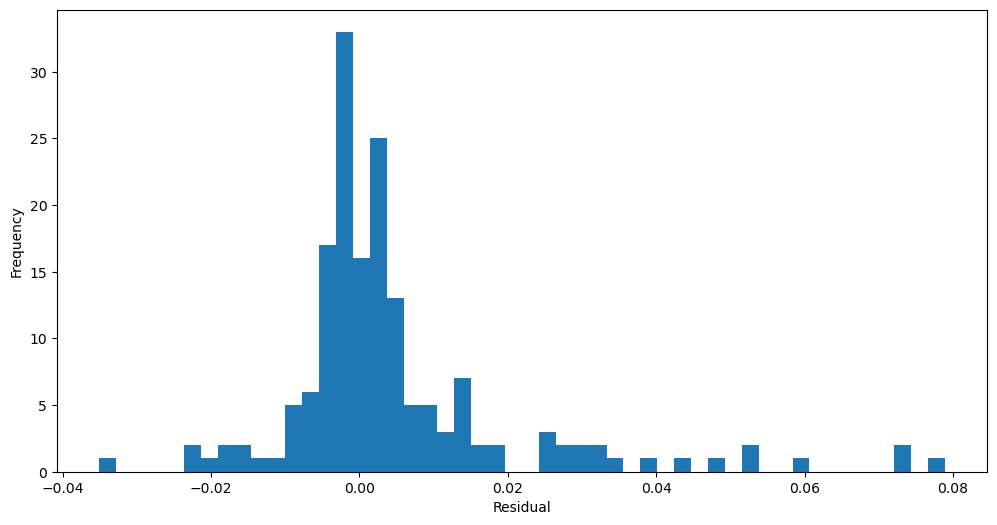

In [25]:
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

The distribution of residuals appears to be approximately normal, with a central peak and tapering tails. This is a positive sign as it suggests that the model's errors are randomly distributed.

The distribution is relatively symmetric around zero, indicating that the model's overpredictions and underpredictions are balanced.

There are a few outliers in the tails of the distribution, suggesting that the model might have difficulty predicting some extreme values.

Resources:

https://github.com/omerbsezer/LSTM_RNN_Tutorials_with_Demo

https://www.youtube.com/watch?v=lhrCz6t7rmQ

https://www.kaggle.com/code/meetnagadia/bitcoin-price-prediction-using-lstm

https://www.researchgate.net/publication/371906687_Predicting_Cryptocurrency_Price_Using_RNN_and_LSTM_Method

https://www.researchgate.net/publication/377467389_Research_on_prediction_of_bitcoin_price_based_on_machine_learning_methods

